In [ ]:
%%capture
!pip install super_gradients
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [ ]:
from IPython.display import clear_output

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [ ]:
from super_gradients.training import models

In [ ]:
PROJECT_DIR = 'retail_checkout_model'
trainer = Trainer(experiment_name='retail_obj_detection', ckpt_root_dir=PROJECT_DIR)

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="fqy6DwWqEuVGOFuUeaYZ")
project = rf.workspace("shreyas-jammi").project("shopping-items")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to shopping-items-1 in yolov5pytorch::   0%|          | 0/530 [00:00<?, ?it/s]

Extracting Dataset Version Zip to shopping-items-1 in yolov5pytorch:: 100%|██████████| 530/530 [00:00<00:00, 7170.72it/s]


In [ ]:
with open('/content/shopping-items-1/data.yaml', 'r') as file:
    data = file.read()
    print(data)

names:
- beverage
- food-box
- fruit
- utility-box
- vegetable
nc: 5
roboflow:
  license: CC BY 4.0
  project: shopping-items
  url: https://universe.roboflow.com/shreyas-jammi/shopping-items/dataset/1
  version: 1
  workspace: shreyas-jammi
test: ../test/images
train: shopping-items-1/train/images
val: shopping-items-1/valid/images



In [ ]:
dataset_params = {
    'data_dir':'/content/shopping-items-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['beverage','food-box','fruit','utility-box','vegetable']
}

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 20/20 [00:00<00:00, 4145.39it/s]


In [ ]:
train_data.dataset.transforms

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees']= 10.42

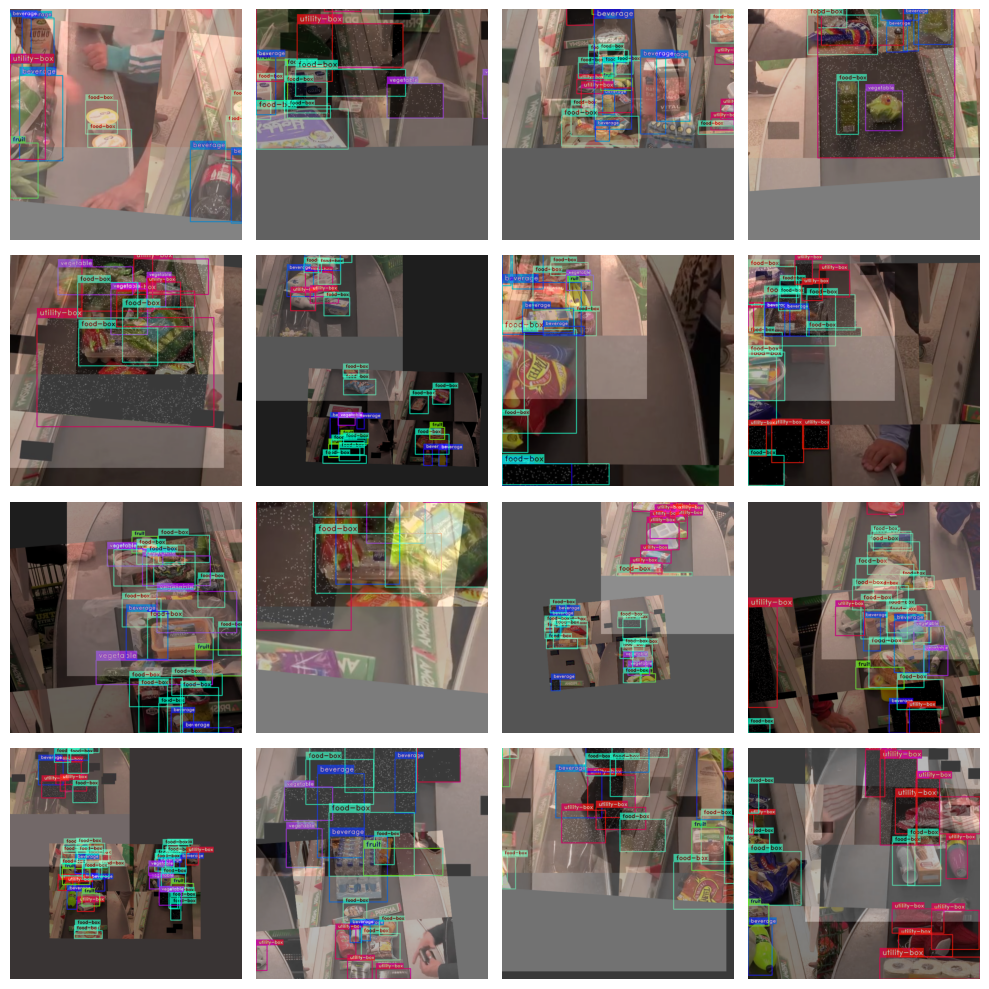

In [ ]:
train_data.dataset.plot()

In [ ]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
)

[2024-02-19 13:57:43] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 239MB/s]
[2024-02-19 13:57:45] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch":'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-02-19 13:58:39] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240219_135839_446832`
[2024-02-19 13:58:39] INFO - sg_trainer.py - Checkpoints directory: retail_checkout_model/retail_obj_detection/RUN_20240219_135839_446832
[2024-02-19 13:58:39] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to retail_checkout_model/retail_obj_detection/RUN_20240219_135839_446832/console_Feb19_13_58_39.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
[2024-02-19 13:58:43] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            195        (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         24      

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="retail_checkout_model/retail_obj_detection/RUN_20240219_135839_446832/ckpt_best.pth")

[2024-02-19 14:08:38] INFO - checkpoint_utils.py - Successfully loaded model weights from retail_checkout_model/retail_obj_detection/RUN_20240219_135839_446832/ckpt_best.pth EMA checkpoint.


In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                    ))

Testing:  67%|██████▋   | 2/3 [00:01<00:00,  2.16it/s]

{'PPYoloELoss/loss_cls': 1.1383879,
 'PPYoloELoss/loss_iou': 0.51284236,
 'PPYoloELoss/loss_dfl': 0.56626415,
 'PPYoloELoss/loss': 2.2174945,
 'Precision@0.50': 0.03147450089454651,
 'Recall@0.50': 0.8503029942512512,
 'mAP@0.50': 0.38458943367004395,
 'F1@0.50': 0.06047137826681137,
 'Best_score_threshold': 0.32999998331069946}

Testing: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


[2024-02-19 14:10:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


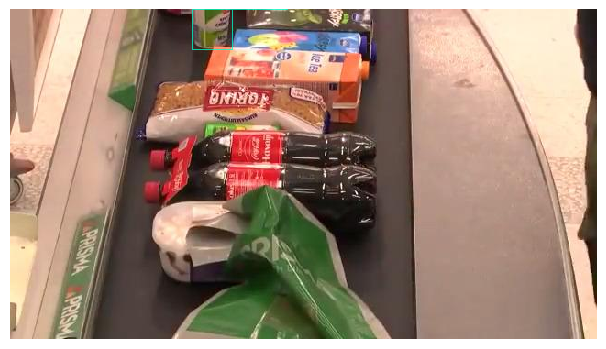

In [ ]:
img_url = '/content/shopping-items-1/test/images/youtube-172_jpg.rf.b295b3b6c4093f6dd42f9a198236cdf4.jpg'
best_model.predict(img_url).show()

[2024-02-19 14:12:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


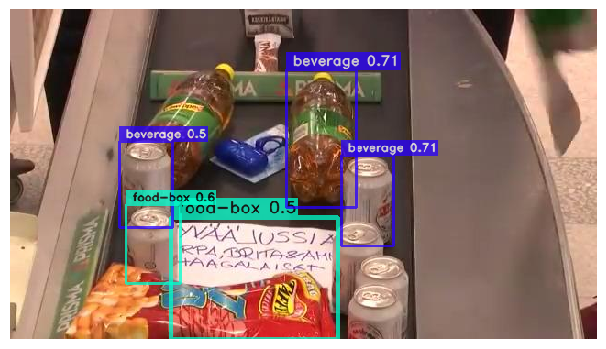

In [ ]:
img_url = '/content/shopping-items-1/valid/images/youtube-138_jpg.rf.7438a79a8815c4c38a10e1d0465facac.jpg'
best_model.predict(img_url).show()

In [ ]:
input_video_path = f"/content/video_input3.mp4"
output_video_path = "/content/output_video3.mp4"

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Processing Video:  99%|█████████▉| 1809/1830 [00:51<00:00, 46.94it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/output_video3.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)